# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil

sns.set()

### Sample Size Calculation

In [6]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.06, 0.09)
effect_size

-0.11445118168989954

In [7]:
# Calculate sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1)

required_n = ceil(required_n)
required_n

1199

### Collecting and preparing the data

In [8]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv('data/tiktok_data.csv')
print(df.shape)
df.head()

(275781, 5)


,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [9]:
# Get the info of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [11]:
# Make sure all the control group are seeing the star button and viceversa
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [13]:
# Check that no users have been sampled multiple times 
session_count = df['user_id'].value_counts()
multiple_users = session_count[session_count > 1].count()
multiple_users


3453

In [15]:
# If there are users who have been sampled multiple times, remove them from the dataframe
print(df.shape)
users_to_drop = session_count[session_count > 1].index
df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape)

(275781, 5)
(268875, 5)


In [18]:
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,134233,110
treatment,109,134423


In [19]:
df_control = df[(df['group'] == 'control')].copy()


# Sanity check that everyone in control group didn't receive new page.
df_control = df_control[df.button != 'star'].copy()

df_treat = df[(df['group'] == 'treatment')].copy()
df_treat = df_treat[df.button != 'heart'].copy()

df_clean = pd.concat([df_control, df_treat], ignore_index=True)


df = df_clean.copy()
df.shape

C:\Users\vicwu\AppData\Local\Temp\ipykernel_14068\2120829072.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_control = df_control[df.button != 'star'].copy()
C:\Users\vicwu\AppData\Local\Temp\ipykernel_14068\2120829072.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat = df_treat[df.button != 'heart'].copy()


(268656, 5)

In [20]:
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,134233,0
treatment,0,134423


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [21]:
# Perform simple random sampling to split the data into control and treatment
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state= 444)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state= 444)


In [22]:
# Create one table called ab_test that has both the cleaned control and treatment data
ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop = True, inplace = True)
ab_test


,user_id,timestamp,group,button,liked
0,923141,2017-01-22 5:57:47,control,heart,0
1,672677,2017-01-06 23:30:47,control,heart,0
2,830874,2017-01-18 23:10:33,control,heart,0
3,824896,2017-01-19 17:45:24,control,heart,0
4,689786,2017-01-15 12:54:08,control,heart,0
...,...,...,...,...,...
2393,878911,2017-01-10 23:42:31,treatment,star,0
2394,744025,2017-01-09 20:31:38,treatment,star,0
2395,733542,2017-01-23 13:21:51,treatment,star,0
2396,793396,2017-01-11 14:40:48,treatment,star,0


In [23]:
# Count the test groups to make sure that they're balanced 
ab_test['group'].value_counts()


control      1199
treatment    1199
Name: group, dtype: int64

### Analysis Visualization

In [27]:
# Find the like rate by group
like_rates = ab_test.groupby('group')['liked']

# Find the Std. deviation of the proportion
#std_proportion = like_rates.agg(['std'])

# Find the Std. error of the proportion (std / sqrt(n))
#std_error = like_rates.agg(['stats.sem'])

# Calculate the final like rate

like_rates = like_rates.agg(['mean', 'std', stats.sem]).reset_index()
like_rates

,group,mean,std,sem
0,control,0.130108,0.336563,0.009720
1,treatment,0.122602,0.328117,0.009476


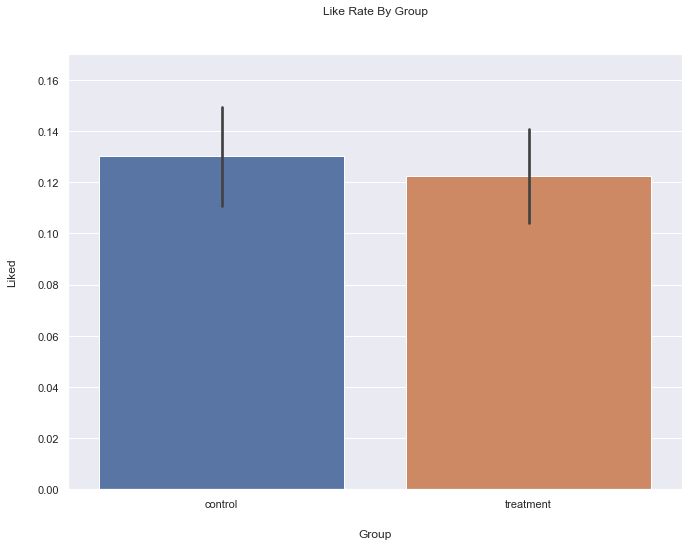

In [29]:
# Plot the like rate by group on a bar plot
plt.figure(figsize = (11,8))

sns.barplot(x = ab_test['group'], y = ab_test['liked'])

plt.ylim(0, 0.17)
plt.title('Like Rate By Group', pad = 40)
plt.xlabel('Group', labelpad = 20)
plt.ylabel('Liked', labelpad = 20);

### Testing for Stat Sig

In [30]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups
control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

number_control = control_results.count()
number_treatment = treatment_results.count()
# Get the number of samples in both groups
number_samples = [number_control, number_treatment]

# Sum up the number of successes (likes) in both groups
successes = [control_results.sum(), treatment_results.sum()]

print(f"# of Control Likes: {number_control} \n# of Treatment Likes: {number_treatment}")
print(f"Total samples: {number_samples[0] + number_samples[1]} ")
print(f"Success from Control: {successes[0]} \nSuccess from Treatment: {successes[1]}")

# of Control Likes: 1199 
# of Treatment Likes: 1199
Total samples: 2398 
Success from Control: 156 
Success from Treatment: 147


In [31]:
# Find the z statistic and p value for proportions based on normal ztest

z_stat, pval = proportions_ztest(
    successes,
    nobs = number_samples)
# Find the confidence intervals for each test group
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=number_samples, alpha=0.5)



In [32]:
# print z statistic
print(f"Z Stats: {z_stat}")
# print p-value
print(f"P val: {pval}")
# print ci 95% for control group
print(f"ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]")
# print ci 95% for treatment group
print(f"ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]")

Z Stats: 0.5531638248838598
P val: 0.5801512355304022
ci 95% for control group: [0.124, 0.137]
ci 95% for treatment group: [0.116, 0.129]


### Were the results signficant? 

The P Val is not below 0.05 so the new design is not performing better than the old one, as we cannot reject the null hypothesis

### What would you advise the engineering team to do moving forward?

Change the design to something else or keep the old design for the button